# Set-up

## Imports

In [211]:
# Standard library
import os
import random
import time
import pickle

# Scientific computation
import numpy as np
from scipy import stats
from sklearn import metrics

# Network science
import networkx as nx
from cdlib import algorithms
from cdlib import evaluation

# Data handling and visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from tqdm import tqdm as tqdm  # Progress bars

## Defining functions

In [212]:
def duplex_network (G, l1, l2, verbose=False):
    """Formats a duplex without inactive nodes or edge overlap.

    Parameters
    ----------
    G : dict
        Map from layer ids to corresponding graphs
    l1 : int
        Id of one of the layers in the resultant duplex
    l2 : int
        Id of the other layer in the resultant duplex
    verbose : bool, optional
        Indicator if verbose printing should be enabled, by default False

    Returns
    -------
    tuple
        Formatted layers of the resultant duplex
    """
    # >>> Book-keeping >>>
    # Create deepcopies of input networks
    G1 = G[l1].copy()
    G2 = G[l2].copy()
    # <<< Book-keeping <<<

    # >>> Duplex construction >>>
    # Remove edges common to both layers
    list_of_common_edges = []

    ## Identify common edges
    for edge in G[l1].edges():
        if G[l2].has_edge(edge[0], edge[1]):  # order safe for undirected networks
            list_of_common_edges.append([e[0], e[1]])

    ## Delete common edges from _both_ layers
    for e in list_of_common_edges:
        G1.remove_edge(e[0], e[1])
        G2.remove_edge(e[0], e[1])

    if verbose:
        print(f"Number of common edges removed: {len(list_of_common_edges)}")

    # Remove nodes with zero degree
    ## Identify nodes in one layer with no activity
    list_of_nodes = []
    for n in G1.nodes():
        if G1.degree(n)==0:
            list_of_nodes.append(n)

    ## Remove inactive nodes from one layer
    for n in list_of_nodes:
        G1.remove_node(n)
    if verbose:
        print(f"Number of inactive nodes removed from layer {l1}: {len(list_of_nodes)}")

    list_of_nodes = []
    ## Identify nodes in other layer with no activity
    for n in G2.nodes():
        if G2.degree(n)==0:
            list_of_nodes.append(n)
    ## Remove inactive nodes from one layer
    for n in list_of_nodes:
        G2.remove_node(n)
    if verbose:
        print(f"Number of inactive nodes removed from layer {l2}: {len(list_of_nodes)}")

    # Ensure node sets equivalent - Create union of nodes
    ## Identify nodes in either layer
    list_of_nodes = []
    for n in G1.nodes():
        list_of_nodes.append(n)
    for n in G2.nodes():
        list_of_nodes.append(n)
    if verbose:
        print(f"Size of active node set union from layers {l1} and {l2}: {len(list_of_nodes)}")
    ## Add nodes to both layers
    for n in list_of_nodes:
        G1.add_node(n)
        G2.add_node(n)
    # <<< Duplex construction <<<

    return G1, G2

In [213]:
def classifier_fully_aware_degree (Etest, degree1, degree2):
    """Classifies each edge into one of two layers based on reconstruction likelihood model.

    Parameters
    ----------
    Etest : dict
        Mapping of edges in aggregate to be reconstructed to their ground truth originating layers
    degree1 : dict
        Mapping of node ids to deree in layer 1
    degree2 : dict
        Mapping of node ids to deree in layer 2

    Returns
    -------
    tuple
        Tuple of lists of the guessed originating layer, the likelihood of that guess, and the true originating layer for each edge in Etest
    """
    # >>> Book-keeping >>>
    classification = []  # reconstructed layers for edges
    scores = []  # strength of reconstruction likelihood
    ground_truth = []  # true originating layers
    # <<< Book-keeping <<<

    # >>> Reconstruction >>>
    for edge in Etest:
        # Unpack edge into its incident nodes
        i = edge[0]
        j = edge[1]

        # Calculate product of degrees of incident nodes in each layer
        degree_product_1 = degree1[i]*degree1[j]
        degree_product_2 = degree2[i]*degree2[j]

        # Calculate likelihood of edge to belong to each layer
        score_1 = score_2 = 0.5
        if degree_product_1 + degree_product_2 > 0.0:
            score_1 = degree_product_1 / (degree_product_1 + degree_product_2)
            score_2 = degree_product_2 / (degree_product_1 + degree_product_2)

        # Determine which layer is predicted for this edge to have originated from
        # Compares score likelihoods for layers
        class_ = random.randint(0,1)
        if score_1 > score_2:
            class_ = 1
        if score_2 > score_1:
            class_ = 0

        # Store calculations
        scores.append(score_1)
        classification.append(class_)
        ground_truth.append(Etest[edge])
    # <<< Reconstruction <<<

    return classification, scores, ground_truth

In [ ]:
def create_test_set_fully_aware_degree (G1, G2):
    """Create an experimental test set from a formatted duplex.

    Parameters
    ----------
    G1 : nx.Graph
        One layer of the formatted duplex
    G2 : nx.Graph
        Another layer of the formatted duplex

    Returns
    -------
    tuple
        Returns dictionaries mapping edge to originating layer and node ids to degrees in layer 1 and 2, respectively
    """
    # >>> Book-keeping >>>
    Etest = {}  # edge -> originating layer
    degree1 = {}  # node -> degree in G1
    degree2 = {}  # node -> degree in G2
    # <<< Book-keeping

    # >>> Test set construction >>>
    # Label edges from G1 as from '1'
    for e in G1.edges():
        Etest[e] = 1

    # Label edges from G2 as from '0'
    for e in G2.edges():
        Etest[e] = 0

    # Track degrees of each node
    # * NOTE: G1, G2 assumed to have been output of `duplex_network`
    # * and have no inactive nodes and the same node sets
    for n in G1:
        degree1[n] = G1.degree(n)
        degree2[n] = G2.degree(n)
    # <<< Test set construction

    return Etest, degree1, degree2

In [ ]:
def generate_power_law (gamma, kmin, kmax):
    """Generate a degree from a powerlaw distribution with exponent value gamma and bounds kmin, kmax.
    """
    xmin = np.power(kmin, 1.0 - gamma)
    xmax = np.power(kmax, 1.0 - gamma)
    x = xmax - random.random()*(xmax - xmin)
    x = np.power(x, 1.0 / (1.0 -gamma))
    return int(x)

In [ ]:
def control_correlation (degree, prob):

    # >>> Book-keeping >>>
    tmp_degree = []  # degrees after shuffling to destroy correlations
    # <<< Book-keeping <<<

    # >>> Modifying correlation >>>
    # Add each original degree sequence to list of degree sequences
    for i in range(len(degree)):
        tmp_degree.append(degree[i])

    # Swap degrees according to specified probability
    for i in range(len(tmp_degree)):
        if random.random()<prob:
            n = tmp_degree[i]
            j = random.randint(0, len(degree)-1)
            tmp_degree[i] = tmp_degree[j]
            tmp_degree[j] = n
    # <<< Modifying correlation <<<

    return tmp_degree

In [ ]:
def generate_configuration_model (degree):
    """Generate a single instance of the configuration model with the specified degree sequence.

    Note that this function exclusively generates undirected and unweighted networks.

    Parameters
    ----------
    degree : list
        Desired degree sequence.

    Returns
    -------
    nx.Graph
        Resultant configuration model sample.
    """

    # >>> Book-keeping >>>
    G = nx.Graph()  # instantiate correctly sized graph
    for n in range(0, len(degree)):
        G.add_node(n)
    edges = []  # edges to add
    # <<< Book-keeping <<<

    # >>> Constructing graph >>>
    # Initialize edges
    for i in range(0, len(degree)):
        k = degree[i]
        for j in range(0, k):
            edges.append(i)

    # Identifying edges with configuration model
    for i in range(0, len(edges)):
        j = random.randint(0, len(edges)-1)
        tmp = edges[i]
        edges[i] = edges[j]
        edges[j] = tmp

    # Adding edges to graph
    for i in range(0, len(edges)-1, 2):
        n = edges[i]
        m = edges[i+1]
        if G.has_edge(n, m) == False and n != m:
            G.add_edge(n, m)
    # <<< Constructing graph <<<

    return G

In [214]:
def generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign):
    """Generate a two-layer multiplex with configuration model layers.

    Parameters
    ----------
    N : int
        Number of nodes
    gamma : float
        Degree sequence exponent. Positive as a parameter.
    kmin : float
        Minimum degree.
    kmax : float
        Maximum degree.
    prob : float
        Proportion of edges to shuffle from one layer to the second.
    sign : int
        Sort of degree sequence when creating second layer. Must be -1 or 1. -1 corresponds to anti-correlated, 1 to correlated.

    Returns
    -------
    dict
        Mapping of layer ids to layers. Default keys 1 and 2.
    """

    # >>> Book-keeping >>>
    degree = []  # layer one degree sequence
    tmp_degree = []  # layer two degree sequence
    G = {}  # dictionary of layers
    # <<< Book-keeping <<<

    # >>> Multiplex construction >>>
    # Sample layer one degree sequence
    for i in range(0, N):
        degree.append(generate_power_law (gamma, kmin, kmax))
    degree = sorted(degree)

    # Construct layer two degree sequence with specified (anti)correlation
    for i in range (0, len(degree)):
        if sign > 0:
            tmp_degree.append(degree[i])
        if sign < 0:
            tmp_degree.append(degree[len(degree)-i-1])
    tmp_degree = control_correlation (tmp_degree, prob)

    # Build layers from degree sequences
    G[1] = generate_configuration_model (degree)
    G[2] = generate_configuration_model (tmp_degree)
    # <<< Multiplex construction <<<

    return G

# Experiment

In [215]:
def perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step):
    """Create figure 1

    Parameters
    ----------
     N : int
        Number of nodes
    kmin : float
        Minimum degree.
    kmax : float
        Maximum degree.
    gamma : float
        Degree sequence exponent. Positive as a parameter.
    sign : int
        Sort of degree sequence when creating second layer. Must be -1 or 1. -1 corresponds to anti-correlated, 1 to correlated.
    step : float
        Step size for sweeping partial observation axis.
    """

    x, y, z = [], [], []

    prob_values = np.linspace(0.0, 1.0, num=10)

    # Sweep partial observation axis
    for i in range(len(prob_values)):
        prob = prob_values[i]

        # Generate duplex to reconstruct
        G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
        G1, G2 = duplex_network (G, 1, 2)

        # Set up experiment
        Etest, degree1, degree2 = create_test_set_fully_aware_degree (G1, G2)

        # Run reconstruction algorithm
        classification, scores, ground_truth = classifier_fully_aware_degree (Etest, degree1, degree2)


        # Track performance
        acc = metrics.accuracy_score(ground_truth, classification)
        auc = metrics.roc_auc_score(ground_truth, scores)
        x.append(prob)
        y.append(acc)
        z.append(auc)

        prob += step

    results = [x, y, z]
    return results

## Figure 1a

In [216]:
N = 100000
kmin = 3
sign = 1
step = 0.1

results = {}

In [217]:
kmax = int(np.sqrt(N))
gamma = 2.1

results[gamma] = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

1749
1263
814
569
443
286
234
147
110
84


In [218]:
kmax = int(np.sqrt(N))
gamma = 2.5

results[gamma]  = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

535
322
230
193
114
85
69
53
39
27


In [219]:
kmax = int(np.sqrt(N))
gamma = 2.9

results[gamma] = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

127
94
77
62
40
36
33
27
19
18


In [220]:
gamma = 3.5
kmax = int(np.power(N, 1.0/(gamma-1.0)))

results[gamma] = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

32
31
17
14
15
17
7
12
14
9


In [222]:
with open('figure1a_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [223]:
with open('figure1a_data.pk', 'rb') as handle:
    results = pickle.load(handle)

(0.0, 1)

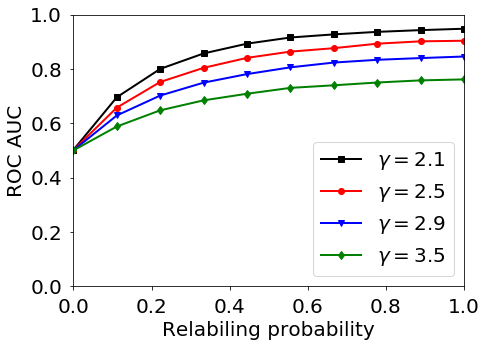

In [224]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

gamma = 2.1
plt.plot(results[gamma][0], results[gamma][2], marker='s', linewidth=2, color = 'black', label='$\gamma = 2.1$')

gamma = 2.5
plt.plot(results[gamma][0], results[gamma][2], marker='o', linewidth=2, color = 'red', label='$\gamma = 2.5$')


gamma = 2.9
plt.plot(results[gamma][0], results[gamma][2], marker='v', linewidth=2, color = 'blue', label='$\gamma = 2.9$')


gamma = 3.5
plt.plot(results[gamma][0], results[gamma][2], marker='d', linewidth=2, color = 'green', label='$\gamma = 3.5$')




plt.legend(loc='lower right')
plt.xlabel('Relabiling probability')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

## Figure 1b

In [225]:
N = 100000
kmin = 3#print ('# option = ', option)
sign = -1
step = 0.1

results = {}

In [226]:
kmax = int(np.sqrt(N))
gamma = 2.1

results[gamma] = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

10
25
32
37
46
51
72
69
75
72


In [227]:
kmax = int(np.sqrt(N))
gamma = 2.5

results[gamma]  = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

15
17
14
24
22
35
37
29
32
36


In [228]:
kmax = int(np.sqrt(N))
gamma = 2.9

results[gamma] = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

12
9
8
11
9
15
17
13
17
19


In [229]:
gamma = 3.5
kmax = int(np.power(N, 1.0/(gamma-1.0)))

results[gamma] = perform_analysis_configuration_model_fully_aware_degree (N, kmin, kmax, gamma, sign, step)

10
12
8
4
7
7
10
5
6
10


In [230]:
with open('figure1b_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('figure1b_data.pk', 'rb') as handle:
    results = pickle.load(handle)

(0.0, 1)

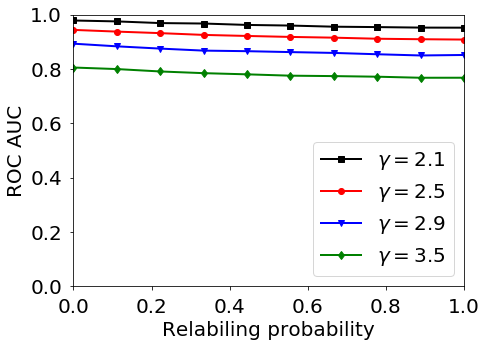

In [21]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

gamma = 2.1
plt.plot(results[gamma][0], results[gamma][2], marker='s', linewidth=2, color = 'black', label='$\gamma = 2.1$')

gamma = 2.5
plt.plot(results[gamma][0], results[gamma][2], marker='o', linewidth=2, color = 'red', label='$\gamma = 2.5$')


gamma = 2.9
plt.plot(results[gamma][0], results[gamma][2], marker='v', linewidth=2, color = 'blue', label='$\gamma = 2.9$')


gamma = 3.5
plt.plot(results[gamma][0], results[gamma][2], marker='d', linewidth=2, color = 'green', label='$\gamma = 3.5$')




plt.legend(loc='lower right')
plt.xlabel('Relabiling probability')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

# LFR Benchmarks

In [62]:
def LFR(n,t1,t2,mu,avg_k,max_k,min_community):
    #function to generate LFR network as a networkx object and obtain community assignments

    # >>> Book-keeping >>>
    # Cast parameters as strings
    N = str(n)
    Mu = str(mu)
    T1 = str(t1)
    T2 = str(t2)
    maxk = str(max_k)
    k = str(avg_k)
    min_community = str(min_community)

    # Concatenate LFR binary shell command as a string
    s='./benchmark -N '+N+' -mu '+Mu+ ' -maxk ' +maxk  + ' -k '+k  +' -t1 ' +T1+' -t2 ' +T2 # +' -minc ' +min_community
    # <<< Book-keeping <<<


    # >>> LFR generation >>>
    # Call LFR binary and generate networks
    os.system(s)

    # Format resultant network as networkx Graph
    x=np.loadtxt('network.dat')
    edges=[(int(x[i][0])-1,int(x[i][1])-1) for i in range(len(x))]
    g=nx.Graph(edges)

    # Format resultant node partition as dict
    x=np.loadtxt('community.dat')
    coms={int(x[i][0])-1:int(x[i][1]) for i in range(len(x))}
    # <<< LFR generation <<<

    return g, coms

In [ ]:
def lfr_multiplex (N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel):

    # >>> Book-keeping >>>
    groups = {}
    # <<< Book-keeping <<<

    # >>> Experimental data sampling >>>
    # Generate LFR network (one layer)
    H, comm = LFR(n=N, t1=tau1, t2=tau2, mu=mu, avg_k=average_degree, max_k = max_degree, min_community=min_community)

    # Create list of communities
    for n in comm:
        c = comm[n]
        if c not in groups:
            groups[c] = []
        groups[c].append(n)


    # Create node -> community mapping
    sigma1 = {}
    for n in comm:
        sigma1[n] = comm[n]


    # Shuffle community labels
    new_labels = {}  # old_community_label -> new_community_label
    for C in groups:
        tmp = groups[C].copy()
        random.shuffle(tmp)
        for i in range(0, len(groups[C])):
            n = groups[C][i]
            m = tmp[i]
            new_labels[n] = m

    # Apply community label shuffling to node -> community mapping
    tmp_sigma2 = {}
    for n in sigma1:
        m = new_labels[n]
        tmp_sigma2[m] = sigma1[n]

    # Form duplex of LFR layers
    G = {}
    G[1] = H.copy()
    G[2] = nx.Graph()

    ## Ensure same node set in both layers
    for n in G[1]:
        G[2].add_node(n)

    ## Add edges to second layer _with label shuffling_
    for e in G[1].edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)

    # Beak community correlation between layers
    list_nodes = list(G[2].nodes())
    new_labels = {}
    H = G[2].copy()
    for n in G[2]:
        new_labels[n] = n
    for n in new_labels:
        if random.random()<prob_relabel:
            m = random.choice(list_nodes)
            tmp = new_labels[n]
            new_labels[n] = new_labels[m]
            new_labels[m] = tmp

    G[2] = nx.Graph()
    for n in H:
        m = new_labels[n]
        G[2].add_node(m)
    for e in H.edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)

    sigma2 = {}
    for n in tmp_sigma2:
        m = new_labels[n]
        sigma2[m] = tmp_sigma2[n]
    # <<< Experimental data sampling <<<

    return G, sigma1, sigma2, mu


In [ ]:
def classifier_fully_aware_community (Etest, sigma1, sigma2, mu):

    # >>> Book-keeping >>>
    classification = []  # list of classifications for each edge
    scores = []  # normalized probability of belonging to "first" layer
    ground_truth = []
    # <<< Book-keeping <<<

    # >>> Reconstruct network >>>
    for e in Etest:
        n = e[0]  # src of edge
        m = e[1]  # tgt of edge

        # Calculate likelihood of belonging to "first" layer
        s1 = 1.0
        if sigma1[n] == sigma1[m]:
            s1 = s1 * mu
        else:
            s1 = s1 * (1.0-mu)

        # Calculate likelihood of belonging to "first" layer
        s2 = 1.0
        if sigma2[n] == sigma2[m]:
            s2 = s2 * mu
        else:
            s2 = s2 * (1.0-mu)

        # Normalize probability of reconstructing edge into "first" layer
        t1 = t2 = 0.5
        if s1 + s2 > 0.0:
            t1 = s1 / (s1 + s2)
            t2 = s2 / (s1 + s2)

        # Declare reconstruction for given edge based on probability calculated above
        s = random.randint(0,1)
        if t1 > t2:
            s = 1
        if t2 > t1:
            s = 0

        # Track likelihoods and classifications for downstream performance analysis
        scores.append(t1)
        classification.append(s)
        ground_truth.append(Etest[e])
    # <<< Reconstruct network <<<


    return classification, scores, ground_truth

In [39]:
def create_test_set_fully_aware_community (G1, G2):

    # >>> Book-keeping >>>
    Etest = {}  # edge -> true layer label mapping
    # <<< Book-keeping <<<

    # >>> Create test set >>>
    # Label "G" edges
    for e in G1.edges():
        Etest[e] = 1

    # Label "H" edges
    for e in G2.edges():
        Etest[e] = 0

    # Retrieve degree sequences
    degree1 = {}
    degree2 = {}
    for n in G1:
        degree1[n] = G1.degree(n)
        degree2[n] = G2.degree(n)
    # <<< Create test set <<<

    return Etest, degree1, degree2


In [47]:
def perform_analysis_lfr_model_fully_aware_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step):

    # >>> Book-keeping >>>
    x = []  # list of relabeling probabilities (control parameter)
    y = []  # list of reconstruction accuracies (performance measurement)
    z = []  # list of reconstruction accuracies (performance measurement)

    num = int(1.0/step)  # number of simulations
    prob_values = np.linspace(0.0, 1.0, num=num)  # fraction of relabeling probabilities over `num` points
    # <<< Book-keeping <<<

    # >>> Experiment >>>
    # Sweep over relabeling probabilities
    for i in range(len(prob_values)):
        prob = prob_values[i]

        # Generate LFR duplex
        G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, tau1, tau2, mu, average_degree, max_degree, min_community, prob)
        G1, G2 = duplex_network (G, 1, 2)
        print (len(G[1].edges()), len(G[1].edges()))
        print (len(G1.edges()), len(G2.edges()))

        # Set up reconstruction experiment
        Etest, degree1, degree2 = create_test_set_fully_aware_community (G1, G2)

        # Apply reconstruction method
        classification, scores, ground_truth = classifier_fully_aware_community (Etest, sigma1, sigma2, 1.0-mu)

        # Measure performance
        acc = metrics.accuracy_score(ground_truth, classification)
        auc = metrics.roc_auc_score(ground_truth, scores)

        # Track performance record
        x.append(prob)
        y.append(acc)
        z.append(auc)

        prob += step

    results = [x, y, z]
    # <<< Experiment <<<

    return results


## Figure 1c

In [190]:
N = 10000

tau1 = 2.1
tau2 = 1.0
average_degree = 20.0
max_degree = int(np.sqrt(N))
#min_community = int(float(N)/10.0)
min_community = 1
step = 0.1


results_lfr = {}

In [191]:
mu = 0.1

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

34184
99612 99612
65428 65428
21062
100807 100807
79745 79745
13069
99287 99287
86218 86218
7400
99904 99904
92504 92504
3952
98938 98938
94986 94986
2447
100669 100669
98222 98222
1229
100379 100379
99150 99150
516
98074 98074
97558 97558
242
99642 99642
99400 99400
197
99501 99501
99304 99304


In [192]:
mu = 0.2

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

28421
101201 101201
72780 72780
17022
100019 100019
82997 82997
10334
99619 99619
89285 89285
6193
98953 98953
92760 92760
3209
99657 99657
96448 96448
1933
99365 99365
97432 97432
896
100977 100977
100081 100081
460
101393 101393
100933 100933
279
101042 101042
100763 100763
202
99729 99729
99527 99527


In [193]:
mu = 0.3

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

21882
99665 99665
77783 77783
12761
100554 100554
87793 87793
8054
100924 100924
92870 92870
4823
100485 100485
95662 95662
2585
100655 100655
98070 98070
1359
99457 99457
98098 98098
739
98799 98799
98060 98060
416
100741 100741
100325 100325
265
101908 101908
101643 101643
193
100583 100583
100390 100390


In [194]:
mu = 0.4

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

15478
101074 101074
85596 85596
9959
99491 99491
89532 89532
6224
99048 99048
92824 92824
3715
100528 100528
96813 96813
2340
100506 100506
98166 98166
1323
100459 100459
99136 99136
694
100763 100763
100069 100069
384
100203 100203
99819 99819
262
100004 100004
99742 99742
173
100943 100943
100770 100770


In [195]:
mu = 0.5

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

10892
99078 99078
88186 88186
7329
100805 100805
93476 93476
5172
101475 101475
96303 96303
2878
99164 99164
96286 96286
1681
100270 100270
98589 98589
818
99492 99492
98674 98674
552
99636 99636
99084 99084
325
99841 99841
99516 99516
234
99863 99863
99629 99629
196
101126 101126
100930 100930


In [196]:
with open('figure1c_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [197]:
with open('figure1c_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

(0.0, 1)

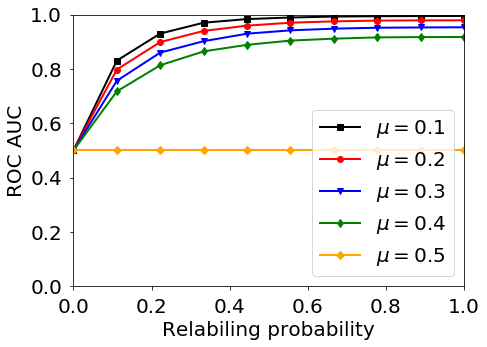

In [198]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

mu = 0.1
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='s', linewidth=2, color = 'black', label='$\mu = 0.1$')

mu = 0.2
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='o', linewidth=2, color = 'red', label='$\mu = 0.2$')


mu = 0.3
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='v', linewidth=2, color = 'blue', label='$\mu = 0.3$')


mu = 0.4
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='d', linewidth=2, color = 'green', label='$\mu = 0.4$')


mu = 0.5
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='D', linewidth=2, color = 'orange', label='$\mu = 0.5$')




plt.legend(loc='lower right')
plt.xlabel('Relabiling probability')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

## Figure 1d

In [102]:
def classifier_fully_aware_degree_community (Etest, degree1, degree2, sigma1, sigma2, mu):
    # >>> Book-keeping >>>
    classification = []  # list of classifications for each edge
    scores = []  # normalized probability of belonging to "first" layer
    ground_truth = []
    # <<< Book-keeping <<<

    # >>> Reconstruct network >>>
    for e in Etest:
        n = e[0]  # src of edge
        m = e[1]  # tgt of edge

        # Calculate likelihood of belonging to "first" layer
        s1 = degree1[n]*degree1[m]
        if sigma1[n] == sigma1[m]:
            s1 = s1 * mu
        else:
            s1 = s1 * (1.0-mu)

        # Calculate likelihood of belonging to "first" layer
        s2 = degree2[n]*degree2[m]
        if sigma2[n] == sigma2[m]:
            s2 = s2 * mu
        else:
            s2 = s2 * (1.0-mu)

        # Normalize probability of reconstructing edge into "first" layer
        t1 = t2 = 0.5
        if s1 + s2 > 0.0:
            t1 = s1 / (s1 + s2)
            t2 = s2 / (s1 + s2)

        # Declare reconstruction for given edge based on probability calculated above
        s = random.randint(0,1)
        if t1 > t2:
            s = 1
        if t2 > t1:
            s = 0

        # Track likelihoods and classifications for downstream performance analysis
        scores.append(t1)
        classification.append(s)
        ground_truth.append(Etest[e])
    # <<< Reconstruct network <<<


    return classification, scores, ground_truth

In [ ]:
def create_test_set_fully_aware_degree_community (G1, G2):
    # >>> Book-keeping >>>
    Etest = {}  # edge -> true layer label mapping
    # <<< Book-keeping <<<

    # >>> Create test set >>>
    # Label "G" edges
    for e in G1.edges():
        Etest[e] = 1

    # Label "H" edges
    for e in G2.edges():
        Etest[e] = 0

    # Retrieve degree sequences
    degree1 = {}
    degree2 = {}
    for n in G1:
        degree1[n] = G1.degree(n)
        degree2[n] = G2.degree(n)
    # <<< Create test set <<<

    return Etest, degree1, degree2

In [103]:
def perform_analysis_lfr_model_fully_aware_degree_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step):
    # >>> Book-keeping >>>
    x = []  # list of relabeling probabilities (control parameter)
    y = []  # list of reconstruction accuracies (performance measurement)
    z = []  # list of reconstruction accuracies (performance measurement)

    num = int(1.0/step)  # number of simulations
    prob_values = np.linspace(0.0, 1.0, num=num)  # fraction of relabeling probabilities over `num` points
    # <<< Book-keeping <<<

    # >>> Experiment >>>
    # Sweep over relabeling probabilities
    for i in range(len(prob_values)):
        prob = prob_values[i]

        # Generate LFR duplex
        G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, tau1, tau2, mu, average_degree, max_degree, min_community, prob)
        G1, G2 = duplex_network (G, 1, 2)
        print (len(G[1].edges()), len(G[1].edges()))
        print (len(G1.edges()), len(G2.edges()))

        # Set up reconstruction experiment
        Etest, degree1, degree2 = create_test_set_fully_aware_degree_community(G1, G2)

        # Apply reconstruction method
        classification, scores, ground_truth = classifier_fully_aware_degree_community(Etest, degree1, degree2, sigma1, sigma2, 1.0-mu)

        # Measure performance
        acc = metrics.accuracy_score(ground_truth, classification)
        auc = metrics.roc_auc_score(ground_truth, scores)

        # Track performance record
        x.append(prob)
        y.append(acc)
        z.append(auc)

        prob += step

    results = [x, y, z]
    # <<< Experiment <<<

    return results

In [199]:
N = 10000

tau1 = 2.1
tau2 = 1.0 
average_degree = 20.0 
max_degree = int(np.sqrt(N)) 
#min_community = int(float(N)/10.0)
min_community = 1
step = 0.1


results_lfr = {}

In [200]:
mu = 0.1

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_degree_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

33076
21338
12494
7632
4740
2510
1131
602
272
219


In [201]:
mu = 0.2

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_degree_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

26752
18655
9818
6460
3716
1874
960
427
260
206


In [202]:
mu = 0.3

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_degree_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

21603
12371
8651
4759
2946
1504
842
383
274
196


In [203]:
mu = 0.4

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_degree_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

16958
10135
6858
4027
2235
1161
732
340
230
211


In [204]:
mu = 0.5

results_lfr[mu] = perform_analysis_lfr_model_fully_aware_degree_community (N, tau1, tau2, mu, average_degree, max_degree, min_community, step)

11832
7680
4615
2730
1728
967
617
307
238
184


In [205]:
with open('figure1d_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [206]:
with open('figure1d_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

(0.0, 1)

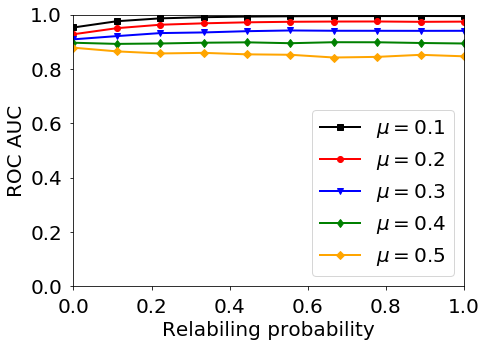

In [207]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

mu = 0.1
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='s', linewidth=2, color = 'black', label='$\mu = 0.1$')

mu = 0.2
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='o', linewidth=2, color = 'red', label='$\mu = 0.2$')


mu = 0.3
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='v', linewidth=2, color = 'blue', label='$\mu = 0.3$')


mu = 0.4
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='d', linewidth=2, color = 'green', label='$\mu = 0.4$')


mu = 0.5
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='D', linewidth=2, color = 'orange', label='$\mu = 0.5$')




plt.legend(loc='lower right')
plt.xlabel('Relabiling probability')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)